# PA5 — Environment & Spark Setup Validation (Colab & Drive)

This notebook provisions a **PySpark** session, logs key configs for reproducibility,
verifies a **Google Drive mount**, and runs a small **sample DataFrame transform**.


**Checklist this notebook covers:**
- PySpark version + Spark session config (memory, shuffle partitions)
- Reproducible config dump to the output
- Google Drive mount confirmation
- Sample DataFrame + a basic transform

## 1) Install / Verify PySpark

In [11]:
# 1) Install Java 17 and expose it to PySpark
!apt-get -y install openjdk-17-jdk-headless

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

# 2) Make sure PySpark version matches Python 3.12 (use >= 3.5)
%pip -q install --upgrade "pyspark==3.5.1"

# 3) Quick sanity check
!java -version
import pyspark, sys
print("PySpark:", pyspark.__version__, "| Python:", sys.version.split()[0])


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-17-jdk-headless is already the newest version (17.0.16+8~us1-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
openjdk version "17.0.16" 2025-07-15
OpenJDK Runtime Environment (build 17.0.16+8-Ubuntu-0ubuntu122.04.1)
OpenJDK 64-Bit Server VM (build 17.0.16+8-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)
PySpark: 3.5.1 | Python: 3.12.12


In [12]:
# If running in Google Colab, (re)install PySpark explicitly.
# In local environments you can skip this cell.
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    %pip -q install pyspark
else:
    print("Not in Colab — skipping PySpark install.")

## 2) System & Python Versions

In [13]:
import sys, platform, os, json, datetime
print("Run timestamp:", datetime.datetime.now().isoformat())
print("Python:", sys.version.replace("\n", " "))
print("Platform:", platform.platform())
print("PID:", os.getpid())

Run timestamp: 2025-11-10T01:17:05.108671
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
PID: 387


## 3) Build Spark Session with Reproducible Config

In [14]:
from pyspark.sql import SparkSession
import multiprocessing, os

# Sensible defaults; tweak as needed
num_cores = max(2, multiprocessing.cpu_count() // 2)
shuffle_parts = max(8, num_cores * 4)  # heuristic for small datasets

# Memory defaults vary by runtime; you can raise/lower if you hit OOMs
driver_mem = os.environ.get("SPARK_DRIVER_MEMORY", "4g")
max_result = os.environ.get("SPARK_DRIVER_MAX_RESULT_SIZE", "2g")

spark = (
    SparkSession.builder
    .appName("PA5_EnvSetup")
    .config("spark.sql.shuffle.partitions", str(shuffle_parts))
    .config("spark.driver.memory", driver_mem)
    .config("spark.driver.maxResultSize", max_result)
    .config("spark.ui.showConsoleProgress", "true")
    .config("spark.sql.session.timeZone", "UTC")
    .getOrCreate()
)

print("Spark version:", spark.version)
print("Master:", spark.sparkContext.master)
print("Default parallelism:", spark.sparkContext.defaultParallelism)
print("Shuffle partitions:", spark.conf.get("spark.sql.shuffle.partitions"))
print("Driver memory:", spark.conf.get("spark.driver.memory"))
print("Max result size:", spark.conf.get("spark.driver.maxResultSize"))

Spark version: 3.5.1
Master: local[*]
Default parallelism: 2
Shuffle partitions: 8
Driver memory: 4g
Max result size: 2g


## 4) Dump Spark Configuration

In [15]:
# Log full Spark conf (sorted) for reproducibility
conf_items = sorted(spark.sparkContext.getConf().getAll())
for k,v in conf_items:
    print(f"{k} = {v}")
print(f"\nTotal {len(conf_items)} Spark conf entries printed.")

spark.app.id = local-1762737425484
spark.app.name = PA5_EnvSetup
spark.app.startTime = 1762737425201
spark.app.submitTime = 1762737184634
spark.driver.extraJavaOptions = -Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.us

## 5) Mount Google Drive (Colab)

In [16]:
# Drive mount (Colab only). Safe to run locally; it will no-op.
try:
    import google.colab  # type: ignore
    from google.colab import drive  # type: ignore
    print("Detected Colab — mounting Google Drive at /content/drive ...")
    drive.mount("/content/drive", force_remount=False)
    DRIVE_MOUNTED = os.path.exists("/content/drive/My Drive") or os.path.exists("/content/drive/MyDrive")
    print("Drive mounted:", DRIVE_MOUNTED)
except Exception as e:
    print("Not in Colab or mount failed:", e)
    DRIVE_MOUNTED = False

Detected Colab — mounting Google Drive at /content/drive ...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted: True


## 6) Test Sample DataFrame Transform & Optional Drive Write

In [17]:
from pyspark.sql import functions as F

# Create a tiny sample DataFrame
data = [
    ("a", 1), ("a", 2), ("b", 5), ("b", 7), ("c", 1), ("c", 1), ("c", 3)
]
df = spark.createDataFrame(data, ["key", "val"])

# Simple, non-trivial transform: groupBy/agg + order
out = (df.groupBy("key")
         .agg(F.count("*").alias("n"), F.avg("val").alias("avg_val"))
         .orderBy(F.desc("n"), F.asc("key")))

print("Sample transform result:")
out.show(truncate=False)

# Optionally, write result to Drive if mounted
out_path = None
if 'DRIVE_MOUNTED' in globals() and DRIVE_MOUNTED:
    base = "/content/drive/MyDrive/pa5_env_setup_output"
    os.makedirs(base, exist_ok=True)
    out_path = os.path.join(base, "sample_out")
    # overwrite for repeated runs
    (out.coalesce(1)
        .write.mode("overwrite")
        .option("header", "true")
        .csv(out_path))
    print("Wrote CSV output to:", out_path)
else:
    print("Drive not mounted; skipping write.")

Sample transform result:
+---+---+------------------+
|key|n  |avg_val           |
+---+---+------------------+
|c  |3  |1.6666666666666667|
|a  |2  |1.5               |
|b  |2  |6.0               |
+---+---+------------------+

Wrote CSV output to: /content/drive/MyDrive/pa5_env_setup_output/sample_out


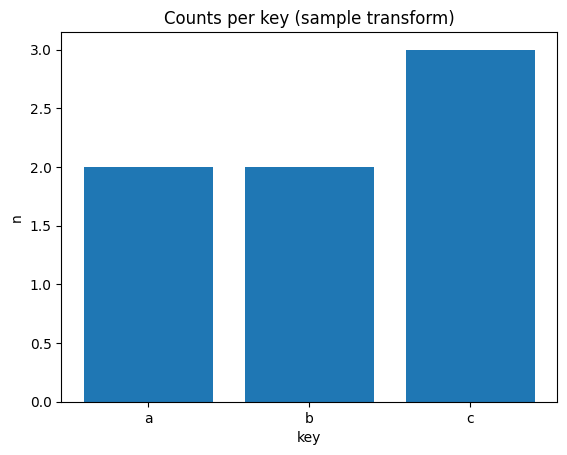

In [18]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

counts = out.select("key","n").orderBy("key").toPandas()

plt.figure()
plt.bar(counts["key"], counts["n"])
plt.title("Counts per key (sample transform)")
plt.xlabel("key")
plt.ylabel("n")
plt.show()


## 7) Cleanup

In [19]:
# Cleanly stop Spark (important on local runs / repeated Colab sessions)
spark.stop()
print("Spark stopped.")

Spark stopped.
